# Natural Language Processing Analysis on Github Repositories: Can We Predict What Language a Repository Utilizes Based on the Wording of the Readme File Associated With It?

## A project by Sandy Graham and Matthew Capper

# Preparation:

### We aim to find an analytical approach to predicting the primary language utilized in a given Github repository based on the words used in the readme.  We will examine words utilized in each repository and take cursory examination of their usage individually, by language, in addition to investigating the distribution of bi-grams and tri-grams within the documents. Document length will also be examined, and we will then utilize our exploration in creating a classification model that can predict the primary language of a repository.

- [X] Acquisition
    - [X] Select what list of repos to scrape.       
        - We have selected a compounded group of repositories from the trending repositories list on github in addition to algorithmically scraped repositories that process through the search pages on Github for those that have been 'starred' the most (i.e. we are selecting generally popular repositories)
        
    - [X] Get requests from the site.
        - This is done utilizing BeautifulSoup and detailed by step in a function called get_all_readme_files_and_languages as found in an acquire.py script
        
    - [X] Save responses to csv.
        - URL extensions are saved to local csv, a list of dictionaries that give us the title, readme, and primary coding language for each repository are saved into a local .json file.  Subsequent queries after initial read from these local files to avoid hitting Github excessively with requests, which wound up being problematic after too many hits.
        
- [X] Preparation
    - [X] Prepare the data for analysis.
        - We will clean our readme data by removing special characters, numbers, and foreign languages and making the text uniform for comparison.  We will examine lemmatized and stemmed words.  We will remove common stopwords as well as the explicit languages so we are not handing ourselves the answer from what the readme might be literally saying, or subsequentally misinterpreting what the readme is saying if it references a language that they did not personally utilize.  For each repository the "Primary Language" is selected so that we are more able to apply a classification model to our dataset.  Scraped from the HTML in our acquire file, the first language class found is used in the script, as they are ordered on Github by percentage used.  If the first instance is listed as a Jupyter Notebook, the second instance is taken due to this being a file format and not a language in the pure sense.


# Environment Set-Up:

In [1]:
# import acquire script: 
from acquire import get_all_readme_files_and_languages
# import prepare scripts: 
from prepare import prepare_repo_html_data
from prepare import basic_clean
# utility imports and pandas for data analysis:
import re
import unicodedata
import numpy as np
import pandas as pd
# import nltk for language analysis: 
import nltk
#matplotlib and seaborn for plotting: 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# scipy.stats for analysis
from scipy.stats import ttest_ind as ttest
from wordcloud import WordCloud
import math
# sentiment analysis importation
from afinn import Afinn

# sklearn for train/test split
from sklearn.model_selection import train_test_split

# bag-of-words and TF-IDF Vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#sklearn for Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# sklearn for model analysis
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report

# ACQUIRE

### Collect the languages and readme files listed for each repo

In [2]:
# initialize our lists of potential excluded and extended stopwords
extra_words = []
exclude_words = []

In [3]:
# gather our repositories through our acquire function:
repositories = get_all_readme_files_and_languages()

# PREPARE

In [4]:
# create a transformed dataset dictionary, as well as a dataframe for exploration
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [5]:
# check key values in transformed dataset
transformed_data[0].keys()

dict_keys(['title', 'language', 'original', 'lemmatized', 'stemmed'])

In [6]:
# check head of dataframe
df.head(3)

language                                         lemmatized  \
0      C++  welcome repository contains source code window...   
1     HTML  python python python c c python python java go...   
2     Ruby  css chat truly monstrous async web chat using ...   

                                            original  \
0  Welcome! This repository contains the source c...   
1  Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...   
2  CSS-Only Chat\nA truly monstrous async web cha...   

                                             stemmed  \
0  welcome repository contains source code window...   
1  python python python c c python python java go...   
2  css chat truly monstrous async web chat using ...   

                       title  
0         microsoft/Terminal  
1  jackfrued/Python-100-Days  
2      kkuchta/css-only-chat

### Create a list of languages that are "cleaned" (lower case with no symbols) so that we can remove them from the readme texts:

In [7]:
# iterate through our dataframe to acquire unique languages, and apply transformation to them
for i in range(df.shape[0]):
    next_lang = transformed_data[i]['language'].lower()
    next_lang = re.sub(r'[^\w\s]', ' ', next_lang).strip()
    if next_lang not in extra_words:
        extra_words.append(next_lang)
# Remove languages from the readme files with another call to prepare_repo_html:
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [8]:
# we will add http, https, com to our extra words to trim needless url information outside of domain,
# we will additionally remove references to github or js (common abbreviation for javascript)
# plus common variable names n and x.  Don't mean anything in the objective sense so we will disregard.
extra_words = extra_words + ['http', 'js', 'https', 'github', 'com', 'x', 'n']
extra_words

['c',
 'html',
 'ruby',
 'vue',
 'java',
 'dart',
 'python',
 'css',
 'rust',
 'shell',
 'javascript',
 'go',
 'typescript',
 'scala',
 'kotlin',
 'smarty',
 'emacs lisp',
 'lua',
 'objective c',
 'tex',
 'common lisp',
 'clojure',
 'jupyter notebook',
 'r',
 'powershell',
 'perl',
 'php',
 'http',
 'js',
 'https',
 'github',
 'com',
 'x',
 'n']

In [9]:
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

### Note that all of the words that reference languages have been removed from the "stemmed" and "lemmatized" versions:

In [10]:
flag = False
for word in df.stemmed[1].split(' ') or word in df.lemmatized[1].split(' '):
    if word in extra_words and word != 'c':
        print(word)
        print()
        flag = True
if flag:
    print('Need to clean more...')
else:
    print('All clean!')

All clean!


### Consider dropping the readmes that are primarily in a non-Roman alphabet.

In [11]:
# Select all the readmes whose stemmed versions are less than 50% as long 
# as the original version's
df[df.stemmed.apply(len) < df.original.apply(len)*.5]

language                                         lemmatized  \
1                HTML  devops matlab lisp make english working langua...   
5                Java  english version readme click leetcode k ii ii ...   
9                Java  offer leetcode linux socket sql leetcode datab...   
16         JavaScript  qianguyihao web web androidweb web issues wiki...   
19               Java  special sponsors programmer advancement snailc...   
23               Java  cat cat cat cat node mvc rpc cat cat cat cat i...   
65               Java  canyuns excelxmind linux version mysql maven p...   
81                Vue  catgate catgate weibo fpizhycatgate url urljso...   
82   Jupyter Notebook  keras keras kaggle dogs vs cats ls train head ...   
100                C#  english version coming soon version catlib cor...   

                                              original  \
1    Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...   
5    There is an English version of README here. ju...   
9    离线阅读版本下载\n\n\n\n\n\n 算法 \n操作系统\n 网络 \n面向对象\n  ...   
16   项目介绍\n\n项目地址：https://github.com/qianguyihao/We...   
19   点击订阅Java面试进阶指南(专为Java面试方向准备)。为什么要弄这个专栏?\n\n\n\...   
23   CAT\n\n\nCAT 简介\n\nCAT 是基于 Java 开发的实时应用监控平台，为美...   
65   捉虫记\n【招聘】Java开发、测试开发等岗位，有意者请将简历投递至<canyuns【@】1...   
81   CatGate\nCatGate 是一个基于浏览器插件的数据抓取工具。做成浏览器插件无需模拟...   
82   本文会通过 Keras 搭建一个深度卷积神经网络来识别一张图片是猫还是狗，在验证集上的准确率...   
100  English version is coming soon in version 2.0\...   

                                               stemmed  \
1    devops matlab lisp make english working langua...   
5    english version readme click leetcode k ii ii ...   
9    offer leetcode linux socket sql leetcode datab...   
16   qianguyihao web web androidweb web issues wiki...   
19   special sponsors programmer advancement snailc...   
23   cat cat cat cat node mvc rpc cat cat cat cat i...   
65   canyuns excelxmind linux version mysql maven p...   
81   catgate catgate weibo fpizhycatgate url urljso...   
82   keras keras kaggle dogs vs cats ls train head ...   
100  english version coming soon version catlib cor...   

                            title  
1       jackfrued/Python-100-Days  
5    MisterBooo/LeetCodeAnimation  
9                CyC2018/CS-Notes  
16                qianguyihao/Web  
19           Snailclimb/JavaGuide  
23                   dianping/cat  
65              youzan/bugCatcher  
81               easychen/catgate  
82             ypwhs/dogs_vs_cats  
100                 CatLib/CatLib

In [12]:
# check row count on current df
df.shape

(183, 5)

In [13]:
# check row count on new df... only losing 10
df[df.stemmed.apply(len) >= df.original.apply(len)*.5].shape

(173, 5)

In [14]:
# drop the rows where the original is in over 50% non-Roman alphabet characters.
df = df[df.stemmed.apply(len) >= df.original.apply(len)*.5]
df.shape

(173, 5)

In [15]:
# peek at new dataframe:
df.head() # dataframe

language                                         lemmatized  \
0      C++  welcome repository contains source code window...   
2     Ruby  chat truly monstrous async web chat using what...   
3     Ruby  overview powertoys set utilities power users t...   
4      Vue  beautifully simple click copy effects cssfx de...   
6     Dart  welcome code repository flutter web repository...   

                                            original  \
0  Welcome! This repository contains the source c...   
2  CSS-Only Chat\nA truly monstrous async web cha...   
3  Overview\nPowerToys is a set of utilities for ...   
4  Beautifully simple click-to-copy CSS effects\n...   
6  Welcome to the code repository for Flutter for...   

                                             stemmed                  title  
0  welcome repository contains source code window...     microsoft/Terminal  
2  chat truly monstrous async web chat using what...  kkuchta/css-only-chat  
3  overview powertoys set utilities power users t...    microsoft/PowerToys  
4  beautifully simple click copy effects cssfx de...         jolaleye/cssfx  
6  welcome code repository flutter web repository...    flutter/flutter_web

### And a clean list of dictionaries:

In [16]:
transformed_data[0] 
# though this still contains the documents written primarily in non-Roman alphabet characters

{'title': 'microsoft/Terminal',
 'language': 'C++',
 'original': 'Welcome! This repository contains the source code for:\n\nWindows Terminal\nThe Windows console host (conhost.exe)\nComponents shared between the two projects\nColorTool\nSample projects that show how to consume the Windows Console APIs\n\nBuild Status\n\n\n\nProject\nBuild Status\n\n\n\n\nTerminal\n\n\n\nColorTool\n\n\n\n\nTerminal & Console Overview\nPlease take a few minutes to review the overview below before diving into the code:\nWindows Terminal\nWindows Terminal is a new, modern, feature-rich, productive terminal application for command-line users. It includes many of the features most frequently requested by the Windows command-line community including support for tabs, rich text, globalization, configurability, theming & styling, and more.\nThe Terminal will also need to meet our goals and measures to ensure it remains fast, and efficient, and doesn\'t consume vast amounts of memory or power.\nThe Windows conso

# EXPLORE

### We will examine the utilization of words in the readme file of these common repositories.  We will examine the frequency of term use through bi-grams and tri-grams, and compare the usage of single words between languages.

In [17]:
# Get the percent of each language that is in the data set.
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'percent']
languages

n   percent
JavaScript        49  0.283237
Python            23  0.132948
C++               14  0.080925
Java              13  0.075145
Go                11  0.063584
Scala              7  0.040462
Ruby               6  0.034682
HTML               6  0.034682
Objective-C        6  0.034682
TypeScript         5  0.028902
Rust               4  0.023121
Kotlin             4  0.023121
Dart               3  0.017341
PHP                3  0.017341
Smarty             2  0.011561
CSS                2  0.011561
Shell              2  0.011561
C                  2  0.011561
C#                 1  0.005780
Jupyter Notebook   1  0.005780
Common Lisp        1  0.005780
TeX                1  0.005780
Emacs Lisp         1  0.005780
Perl               1  0.005780
Lua                1  0.005780
Clojure            1  0.005780
R                  1  0.005780
Vue                1  0.005780
PowerShell         1  0.005780

In [18]:
df.stemmed[:5] # peek at the stemmed data series

0    welcome repository contains source code window...
2    chat truly monstrous async web chat using what...
3    overview powertoys set utilities power users t...
4    beautifully simple click copy effects cssfx de...
6    welcome code repository flutter web repository...
Name: stemmed, dtype: object

In [19]:
# Get the word count and frequency for all of the readmes:
all_words = ' '.join(df.stemmed)
word_freq_for_all = pd.Series(all_words.split()).value_counts()

In [20]:
# Create a list of word frequencies per language: 
list_of_words_per_doc = [{
        'language': 'all',
        'lang_word_list': word_freq_for_all.head(20)
        }]
for repo_num in range(1, len(transformed_data)):
    word_freq_per_language ={
        'language': transformed_data[repo_num]['language'],
        'lang_word_list': pd.Series(transformed_data[repo_num]['stemmed'].split()).value_counts().head(20)
        }
    
    # have to append a copy or I'm only appending the spot that this variable points to 
    # and only end up with the last dictionary in the list.
    list_of_words_per_doc.append(word_freq_per_language)
list_of_words_per_doc

[{'language': 'all', 'lang_word_list': use          1333
  data          968
  const         828
  library       781
  using         725
  array         720
  function      701
  code          646
  object        539
  component     528
  value         516
  simple        499
  b             495
  top           483
  server        483
  learning      474
  new           454
  file          451
  examples      448
  build         446
  dtype: int64}, {'language': 'HTML', 'lang_word_list': api              8
  django           7
  linux            7
  websocket        4
  py               4
  selenium         4
  restful          4
  app              3
  manage           3
  json             3
  nosql            2
  gunicornuwsgi    2
  dayk             2
  sql              2
  web              2
  nginxuwsgi       2
  ip               2
  cookie           2
  tornado          2
  rest             2
  dtype: int64}, {'language': 'Ruby', 'lang_word_list': button        11
  data          

### We will take a look at the most common languages by value count in our dataframe and classify from there

In [21]:
df.language.value_counts()

JavaScript          49
Python              23
C++                 14
Java                13
Go                  11
Scala                7
Ruby                 6
HTML                 6
Objective-C          6
TypeScript           5
Rust                 4
Kotlin               4
Dart                 3
PHP                  3
Smarty               2
CSS                  2
Shell                2
C                    2
C#                   1
Jupyter Notebook     1
Common Lisp          1
TeX                  1
Emacs Lisp           1
Perl                 1
Lua                  1
Clojure              1
R                    1
Vue                  1
PowerShell           1
Name: language, dtype: int64

## We will take a look at the words of the top 8 languages listed by value counts, excluding HTML (everything with 6 or more instances)

In [22]:
# Create a list of the first nine languages by value count.
top_languages = list(df.language.value_counts()[0:9].index)
top_languages

['JavaScript',
 'Python',
 'C++',
 'Java',
 'Go',
 'Scala',
 'Ruby',
 'HTML',
 'Objective-C']

In [23]:
# Remove HTML.
top_languages.remove('HTML')

In [24]:
# Peek at our top language list.
top_languages

['JavaScript', 'Python', 'C++', 'Java', 'Go', 'Scala', 'Ruby', 'Objective-C']

In [25]:
# Reduce dataframe to top 8 languages.
df = df[df.language.isin(top_languages)]

In [26]:
# See how many samples we are left with:
df.shape

(129, 5)

In [27]:
# Ensure that the trimming worked:
df.language.value_counts()

JavaScript     49
Python         23
C++            14
Java           13
Go             11
Scala           7
Objective-C     6
Ruby            6
Name: language, dtype: int64

## We have 135 samples and 8 different languages for classification! A great start.  Let's get our hands dirty.

In [28]:
# obtain word count and frequency for entire data set:
all_words = ' '.join(df.stemmed)
word_freq_for_all = pd.Series(all_words.split()).value_counts()

In [29]:
# make words based on joined strings where dataframe criteria meets stated conditions:
javascript_words = ' '.join(df[df.language == 'JavaScript'].stemmed)
cplusplus_words = ' '.join(df[df.language == 'C++'].stemmed)
python_words = ' '.join(df[df.language == 'Python'].stemmed)
java_words = ' '.join(df[df.language == 'Java'].stemmed)
go_words = ' '.join(df[df.language == 'Go'].stemmed)
ruby_words = ' '.join(df[df.language == 'Ruby'].stemmed)
scala_words = ' '.join(df[df.language == 'Scala'].stemmed)
obj_c_words = ' '.join(df[df.language == 'Objective-C'].stemmed)

In [30]:
# calculate word frequencies for each large string of language-use words
javascript_freq = pd.Series(javascript_words.split()).value_counts()
cplusplus_freq = pd.Series(cplusplus_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
ruby_freq = pd.Series(ruby_words.split()).value_counts()
scala_freq = pd.Series(scala_words.split()).value_counts()
obj_c_freq = pd.Series(obj_c_words.split()).value_counts()

In [31]:
# get word counts together and concatinate them into a single dataframe:

word_counts = (pd.concat([word_freq_for_all, javascript_freq, cplusplus_freq, python_freq, java_freq, go_freq, ruby_freq, scala_freq, obj_c_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'cplusplus', 'python', 'java', 'go', 'ruby', 'scala', 'obj_c'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

#peek at top head of word counts and tail of word counts
word_counts.head().append(word_counts.tail())

all  javascript  cplusplus  python  java  go  ruby  scala  obj_c
a              3           1          0       2     0   0     0      0      0
aa             2           1          0       0     0   0     1      0      0
aaaaaadbzru    1           0          0       0     0   0     0      1      0
aabbceg        1           1          0       0     0   0     0      0      0
aac            1           0          0       0     0   1     0      0      0
zxcvbn         1           1          0       0     0   0     0      0      0
zxf            1           0          0       1     0   0     0      0      0
zynga          1           0          0       1     0   0     0      0      0
zyszys         1           1          0       0     0   0     0      0      0
zyszysgmail    1           1          0       0     0   0     0      0      0

## Let's investigate the most common words across our data set:

In [32]:
# most common words (stemmed) across data set
word_counts.sort_values(by='all', ascending=False).head(10)

all  javascript  cplusplus  python  java   go  ruby  scala  obj_c
use       1101         770         22     176    25   53    17     19     19
data       910         344         20     423    14   88    11      9      1
const      822         819          3       0     0    0     0      0      0
library    764          95         26     323     6  270     5     31      8
array      706         690          0      10     0    3     0      2      1
function   685         634         16      20     7    6     0      2      0
using      635         378         26     125    12   74     8      6      6
code       543         224         44     133    21   89    12     11      9
object     497         393         37      53     1    7     0      1      5
value      489         333         33      76     8   29     0      0     10

### JavaScript, Python, Java, and C++ are the most common languages, so let's look at them.

In [33]:
pd.concat([word_counts.sort_values(by='javascript').tail(3),
           word_counts.sort_values(by='python').tail(3),
           word_counts.sort_values(by='java').tail(3),
          word_counts.sort_values(by='cplusplus').tail(3)])

all  javascript  cplusplus  python  java   go  ruby  scala  obj_c
array      706         690          0      10     0    3     0      2      1
use       1101         770         22     176    25   53    17     19     19
const      822         819          3       0     0    0     0      0      0
library    764          95         26     323     6  270     5     31      8
learning   456          28         16     388     0   22     0      2      0
data       910         344         20     423    14   88    11      9      1
flowable    34           0          0       0    34    0     0      0      0
license    184          65         14      16    36   16    10     23      4
type       259         100         13      46    37   15     2     32     14
cache      223          77         58      72     1   13     0      2      0
swift       98           3         72      12     0    0     0      0     11
build      376         203         74      24     9   47     3      8      8

In [34]:
# Look at only Javascript and Python
# Look at the word counts in one language when the other does not have any occurences 
# of that word.
jvs_pyt = pd.DataFrame() 
jvs_pyt = pd.concat([word_counts[word_counts.python == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='python').tail()])
jvs_pyt[['all', 'javascript', 'python']]

all  javascript  python
obj        198         198       0
val        300         269       0
arr        304         304       0
prototype  356         351       0
const      822         819       0
julia       47           0      45
science     55           0      46
weeks       55           0      54
natural     75           0      64
httpie     101           0     101

In [35]:
# compare difference between javascript and python top words
pd.concat([word_counts[['javascript', 'python']][word_counts.javascript == 0].sort_values(by='python').tail(6),
           word_counts[['javascript', 'python']][word_counts.python == 0].sort_values(by='javascript').tail(6)])

javascript  python
thefuck             0      39
julia               0      45
science             0      46
weeks               0      54
natural             0      64
httpie              0     101
vuex              183       0
obj               198       0
val               269       0
arr               304       0
prototype         351       0
const             819       0

### Let's compare Javascript and Java.

In [36]:
jvs_java = pd.DataFrame() 
jvs_java = pd.concat([word_counts[word_counts.java == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='java').tail()])
jvs_java[['all', 'javascript', 'java']]

all  javascript  java
arr         304         304     0
prototype   356         351     0
component   466         458     0
array       706         690     0
const       822         819     0
println      16           0    16
reactivex    21           0    21
schedulers   22           0    21
rxjava       29           0    28
flowable     34           0    34

### And now Javascript and C++...

In [37]:
jvs_cpp = pd.DataFrame() 
jvs_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='cplusplus').tail()])
jvs_cpp[['all', 'javascript', 'cplusplus']]

all  javascript  cplusplus
val        300         269          0
arr        304         304          0
b          476         372          0
component  466         458          0
array      706         690          0
pypi        19           0          8
catboost    17           0         13
gpu         36           0         14
cmake       16           0         15
xcode       33           0         20

### And Python and Java...

In [38]:
pyt_java = pd.DataFrame() 
pyt_java = pd.concat([word_counts[word_counts.java == 0].sort_values(by='python').tail(),
           word_counts[word_counts.python == 0].sort_values(by='java').tail()])
pyt_java[['all', 'python', 'java']]

all  python  java
django      115     104     0
database    213     108     0
framework   304     111     0
machine     337     288     0
learning    456     388     0
println      16       0    16
schedulers   22       0    21
reactivex    21       0    21
rxjava       29       0    28
flowable     34       0    34

### Python and C++

In [39]:
pyt_cpp = pd.DataFrame() 
pyt_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='python').tail(),
           word_counts[word_counts.python == 0].sort_values(by='cplusplus').tail()])
pyt_cpp[['all', 'python', 'cplusplus']]

all  python  cplusplus
planet         58      56          0
output        106      76          0
b             476      78          0
httpie        101     101          0
deprecated    167     159          0
generatefunc   20       0         10
toolchain      12       0         11
nightly        18       0         14
xcode          33       0         20
ninja          26       0         23

### Java and C++

In [40]:
java_cpp = pd.DataFrame() 
java_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='java').tail(),
           word_counts[word_counts.java == 0].sort_values(by='cplusplus').tail()])
java_cpp[['all', 'java', 'cplusplus']]

all  java  cplusplus
elasticsearch   47    20          0
schedulers      22    21          0
reactivex       21    21          0
v              187    22          0
flowable        34    34          0
key            300     0         25
framework      304     0         32
tensorflow      75     0         36
electron        85     0         48
swift           98     0         72

### Let's create a bar graph to visualize the proportion of language for each of the 20 most common words.

Text(0.5, 1.0, 'Proportion of language for the 20 most common words')

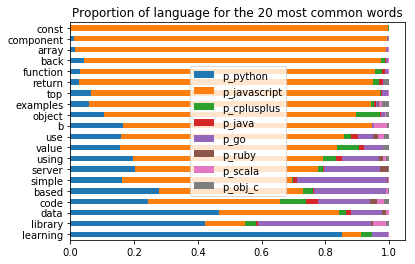

In [41]:
(word_counts
 .assign(p_python = word_counts.python / word_counts['all'],
         p_javascript = word_counts.javascript / word_counts['all'], 
         p_cplusplus = word_counts.cplusplus / word_counts['all'],
         p_java = word_counts.java / word_counts['all'], 
         p_go = word_counts.go / word_counts['all'], 
         p_ruby = word_counts.ruby / word_counts['all'], 
         p_scala = word_counts.scala / word_counts['all'],
         p_obj_c = word_counts.obj_c / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_javascript', 'p_cplusplus', 'p_java', 'p_go', 'p_ruby', 'p_scala', 'p_obj_c']]
 .tail(20)
 .sort_values('p_javascript')
 .plot.barh(stacked=True))

plt.title('Proportion of language for the 20 most common words')

# So the most common words will likely be good predictors of the language. "const" is a very strong predictor of Javascript and "learning" is an almost as strong predictor of Python.

# Let's visualize the words common for each language in word clouds.

### First, all words:

(-0.5, 799.5, 399.5, -0.5)

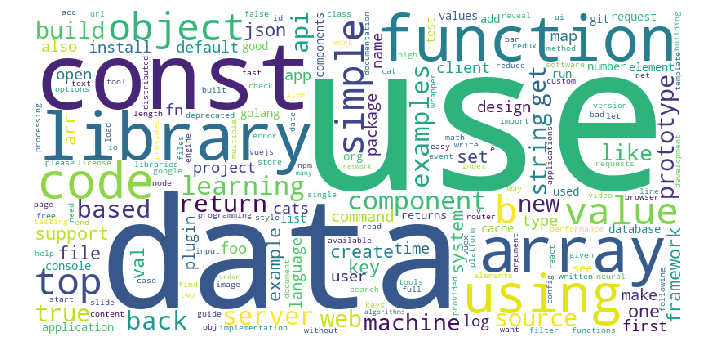

In [42]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(word_freq_for_all)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

# Print the most common words per language and
# Create wordclouds for each language

Top words in All Readme Files
use         1101
data         910
const        822
library      764
array        706
function     685
using        635
code         543
object       497
value        489
dtype: int64
Top words in Javascript
const        819
use          770
array        690
function     634
component    458
top          432
back         400
object       393
examples     382
using        378
dtype: int64
Top words in Python
data          423
learning      388
library       323
machine       288
use           176
deprecated    159
system        153
source        149
design        135
command       134
dtype: int64
Top words in C++
build         74
swift         72
cache         58
electron      48
source        46
code          44
object        37
windows       36
tensorflow    36
open          34
dtype: int64
Top words in Java
type        37
license     36
flowable    34
single      29
rxjava      28
system      27
index       26
source      25
use         25
io          25

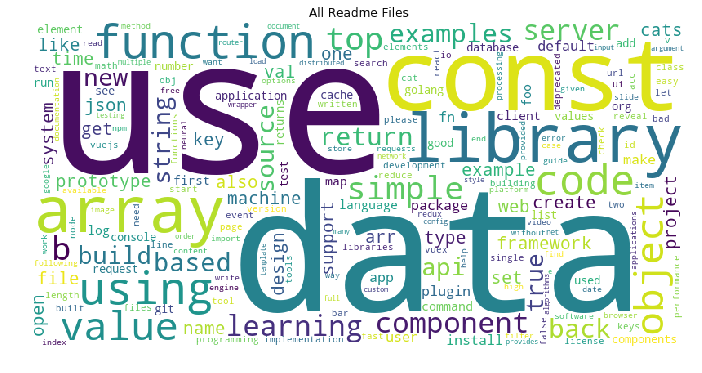

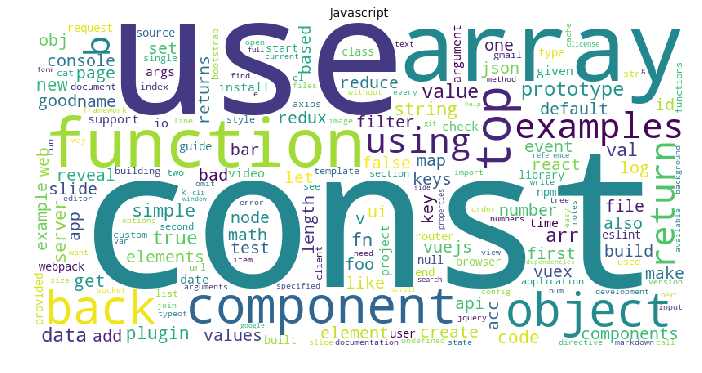

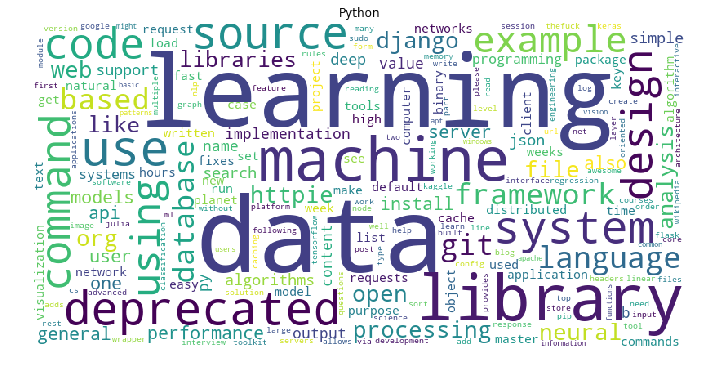

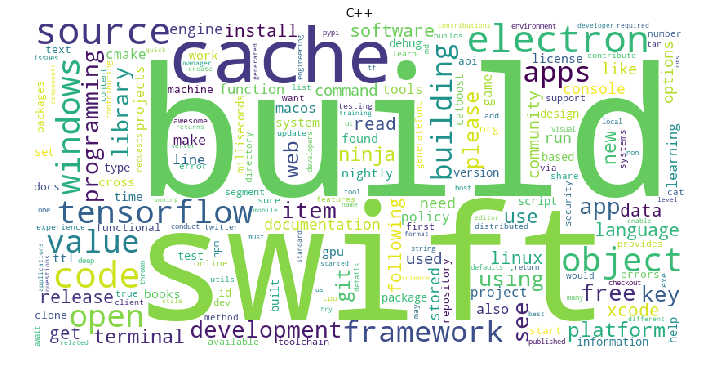

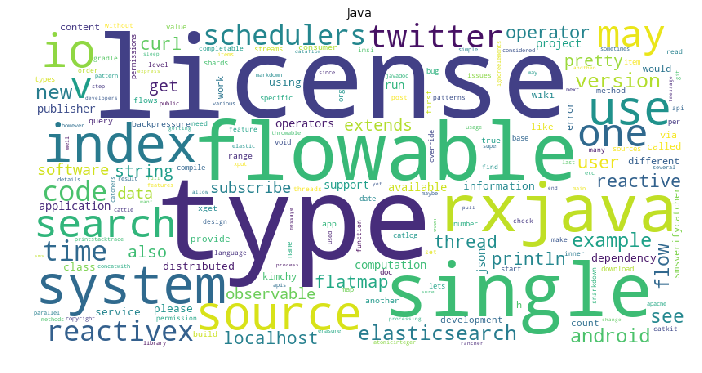

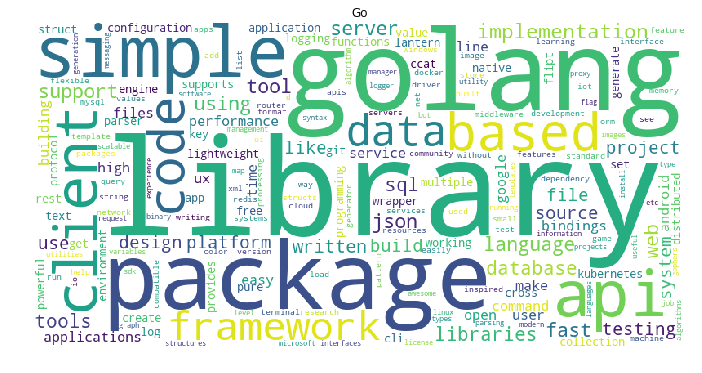

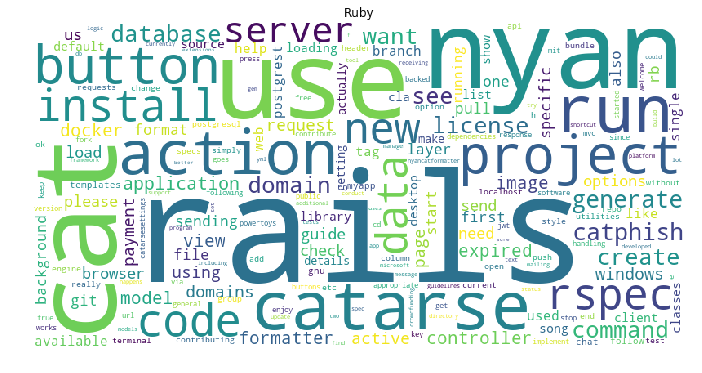

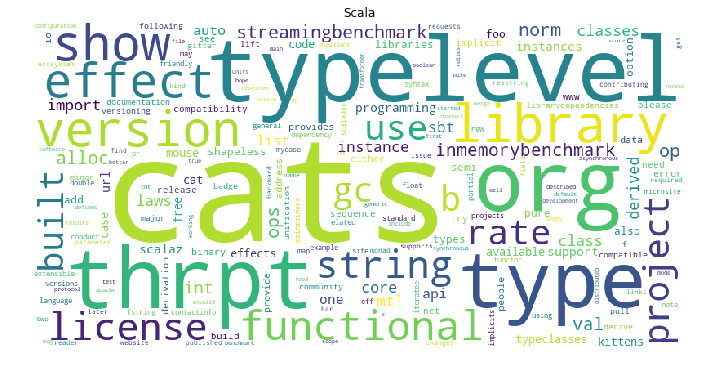

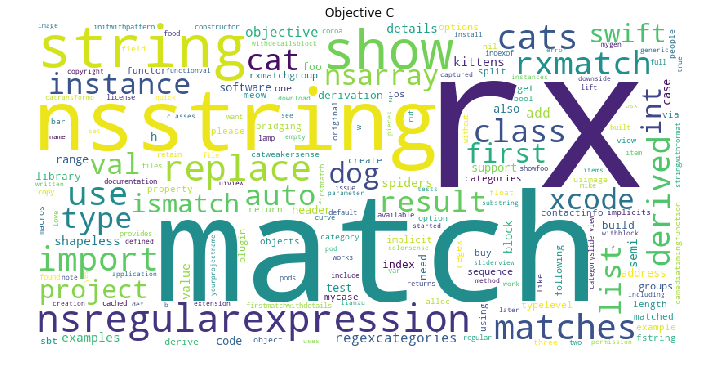

In [43]:
#create a list of our word frequencies and create a word cloud for each iteratively
freq_list = [word_freq_for_all, javascript_freq, python_freq, cplusplus_freq, java_freq, go_freq, ruby_freq, scala_freq, obj_c_freq]
langs = ['All Readme Files', 'Javascript', 'Python', 'C++', 'Java', 'Go', 'Ruby', 'Scala', 'Objective C']
for n, item in enumerate(freq_list): 
    print('Top words in ' + langs[n])
    print(item[0:10])
    cloud = WordCloud(background_color='white', width=800, height=400)
    all_img = cloud.generate_from_frequencies(item)
    plt.figure(figsize=(20, 6))
    plt.imshow(all_img)
    plt.title(langs[n])
    plt.axis('off')

### What does the distribution of IDFs (inverse document frequencies) look like for the most common words?

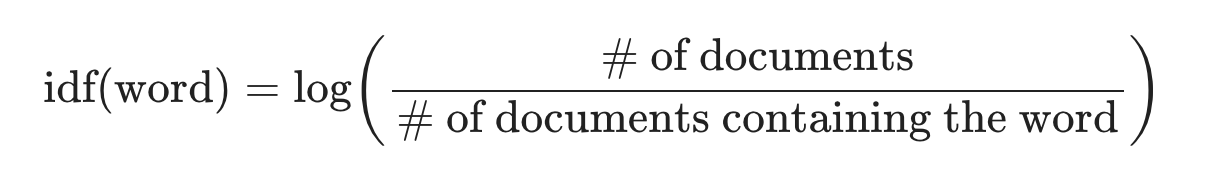

# Calculate IDF for each document
Inverse document frequency tells us how much information a word provides. It is based on how commonly a word appears across multiple documents. The metric is divised such that the more frequently a word appears, the lower the idf for that word will be.

In [45]:
idf = pd.Series()
top_20_words_from_all = list_of_words_per_doc[0]['lang_word_list'].index
for num, word in enumerate(top_20_words_from_all): 
    num_docs_with_word = 0
    
    # check each word list for this word
    for repo_word_list in list_of_words_per_doc[1:]:
        if word in repo_word_list['lang_word_list']:
            num_docs_with_word += 1
    numerator = len(list_of_words_per_doc)-1
    denominator = num_docs_with_word
    fraction = numerator/denominator
    idf[word] = math.log10(fraction)

idf.sort_values()

code         0.561101
use          0.578830
data         0.797673
build        0.845098
using        0.879860
file         0.981318
server       1.146128
new          1.180890
library      1.180890
function     1.260071
simple       1.356981
object       1.414973
b            1.414973
learning     1.481920
value        1.561101
component    1.561101
const        1.658011
examples     1.658011
top          1.782950
array        1.959041
dtype: float64

### Some of the top twenty most common words across the documents have low idf values, meaning they might be too common across documents. Let's check if the low values are actually outliers. If they are, we will drop them to focus on the most common words that are likely to distinguish between programming languages.
Calculate outliers in the idf list.

In [ ]:
outliers=[]
def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        print(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

outlier_datapoints = detect_outlier(idf.sort_values().values)
print('The list of outliers is: ', outlier_datapoints)

### No outliers, so we won't drop any words based on idf.

# Let's create a dataframe containing the ten most common words per language with their word counts.

In [44]:
word_freq_for_all.values[:10]

array([1101,  910,  822,  764,  706,  685,  635,  543,  497,  489])

In [46]:
combined_freq_df = pd.DataFrame()
combined_freq_df['all_w'] = word_freq_for_all.index[:10]
combined_freq_df['all_v'] = word_freq_for_all.values[:10]

combined_freq_df['js_w'] = javascript_freq .index[:10]
combined_freq_df['js_v'] = javascript_freq .values[:10]

combined_freq_df['cpp_w'] = cplusplus_freq.index[:10]
combined_freq_df['cpp_v'] = cplusplus_freq.values[:10]

combined_freq_df['python_w'] = python_freq.index[:10]
combined_freq_df['python_v'] = python_freq.values[:10]

combined_freq_df['java_w'] = java_freq.index[:10]
combined_freq_df['java_v'] = java_freq.values[:10]

combined_freq_df['go_w'] = go_freq.index[:10]
combined_freq_df['go_v'] = go_freq.values[:10]

combined_freq_df['ruby_w'] = ruby_freq.index[:10]
combined_freq_df['ruby_v'] = ruby_freq.values[:10]

combined_freq_df['scala_w'] = scala_freq.index[:10]
combined_freq_df['scala_v'] = scala_freq.values[:10]

combined_freq_df['obj_c_w'] = obj_c_freq.index[:10]
combined_freq_df['obj_c_v'] = obj_c_freq.values[:10]

combined_freq_df

all_w  all_v       js_w  js_v       cpp_w  cpp_v    python_w  python_v  \
0       use   1101      const   819       build     74        data       423   
1      data    910        use   770       swift     72    learning       388   
2     const    822      array   690       cache     58     library       323   
3   library    764   function   634    electron     48     machine       288   
4     array    706  component   458      source     46         use       176   
5  function    685        top   432        code     44  deprecated       159   
6     using    635       back   400      object     37      system       153   
7      code    543     object   393     windows     36      source       149   
8    object    497   examples   382  tensorflow     36      design       135   
9     value    489      using   378        open     34     command       134   

     java_w  java_v       go_w  go_v   ruby_w  ruby_v     scala_w  scala_v  \
0      type      37    library   270    rails      37        cats      183   
1   license      36     golang   198      cat      19   typelevel       41   
2  flowable      34    package   139      use      17         org       36   
3    single      29     simple   137     nyan      17       thrpt       36   
4    rxjava      28        api   109  catarse      17        type       32   
5    system      27     client    92      run      16     library       31   
6     index      26      based    91   action      14     version       27   
7    source      25       code    89  project      13        show       27   
8       use      25       data    88   button      13      effect       26   
9        io      25  framework    88  install      12  functional       26   

               obj_c_w  obj_c_v  
0                   rx       82  
1                match       43  
2             nsstring       40  
3               string       33  
4                 show       28  
5  nsregularexpression       25  
6              replace       22  
7              matches       20  
8                 cats       20  
9                  use       19

# Now let's examine the length of the readme files.

In [47]:
# sanity check: ensure there are only the top 8 languages in our dataframe:
df.language.value_counts()

JavaScript     49
Python         23
C++            14
Java           13
Go             11
Scala           7
Objective-C     6
Ruby            6
Name: language, dtype: int64

### Here, we will create a series of the total count of words divided by the number of instances where that language occurs in our dataframe.  This will produce a visual list of the average number of words in each readme per language.

In [48]:
lengths = pd.Series([len(all_words.split(' '))/df.shape[0],\
                     len(javascript_words.split(' '))/df[df.language=='JavaScript'].shape[0],\
                     len(python_words.split(' '))/df[df.language=='Python'].shape[0],\
                     len(go_words.split(' '))/df[df.language=='Go'].shape[0],\
                     len(cplusplus_words.split(' '))/df[df.language=='C++'].shape[0],\
                     len(java_words.split(' '))/df[df.language=='Java'].shape[0],\
                     len(scala_words.split(' '))/df[df.language=='Scala'].shape[0],\
                     len(ruby_words.split(' '))/df[df.language=='Ruby'].shape[0],\
                     len(obj_c_words.split(' '))/df[df.language=='Objective-C'].shape[0]],\
                    ['all', 'javascript', 'python', 'go', 'cpp', 'java', 'scala', 'ruby', 'obj_c'],
    )
print('Average Word Count of Readme.md by language')
print(lengths)

Average Word Count of Readme.md by language
all           1123.604651
javascript    1458.244898
python        1611.826087
go            1578.090909
cpp            479.857143
java           342.076923
scala          525.142857
ruby           321.500000
obj_c          381.666667
dtype: float64


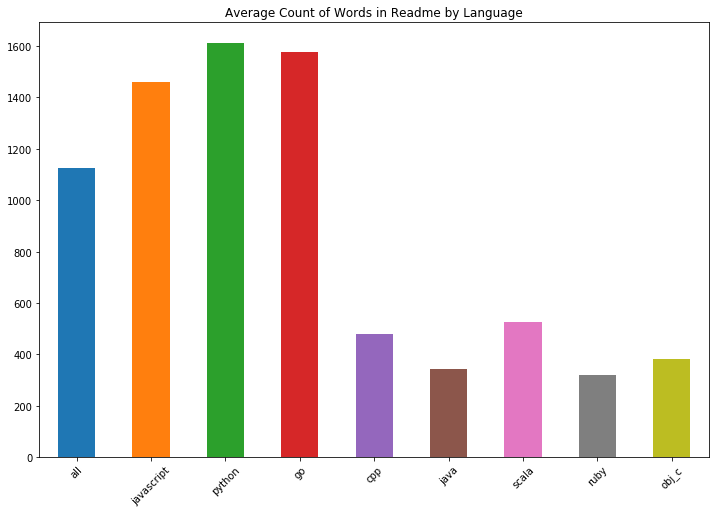

In [49]:
#plot the series of average word counts: 
lengths.plot.bar(figsize=(12,8))
plt.title('Average Count of Words in Readme by Language')
plt.xticks(rotation=45)
plt.show()

## We can note that there is an elevated number of words in Python specifically, but not to a degree of outlying compared to javascript or go.  The less popular languages also appear to have a highly reduced number of words in the readme.  It would be interesting to investigate if this is based on age or demographic of these particular coding languages and the cultures surrounding them vs the more popular ones, which are the more en-vogue coding languages of the current era.

# Now let's consider pairs of words (bigrams).

In [50]:
#create our bigrams using nltk, selecting 2 for n in ngrams, made into a series and sorted by value counts
all_bigrams = pd.Series(nltk.ngrams(all_words.strip().split(' '), 2)).value_counts()
js_bigrams = pd.Series(nltk.ngrams(javascript_words.split(' '), 2)).value_counts()
py_bigrams = pd.Series(nltk.ngrams(python_words.split(' '), 2)).value_counts()
java_bigrams = pd.Series(nltk.ngrams(java_words.split(' '), 2)).value_counts()
cplusplus_bigrams = pd.Series(nltk.ngrams(cplusplus_words.split(' '), 2)).value_counts()
go_bigrams = pd.Series(nltk.ngrams(go_words.split(' '), 2)).value_counts()
scala_bigrams = pd.Series(nltk.ngrams(scala_words.split(' '), 2)).value_counts()
ruby_bigrams = pd.Series(nltk.ngrams(ruby_words.split(' '), 2)).value_counts()
objc_bigrams = pd.Series(nltk.ngrams(obj_c_words.split(' '), 2)).value_counts()

Text(0.5, 1.0, '20 Most frequently occuring bigrams in all readme files')

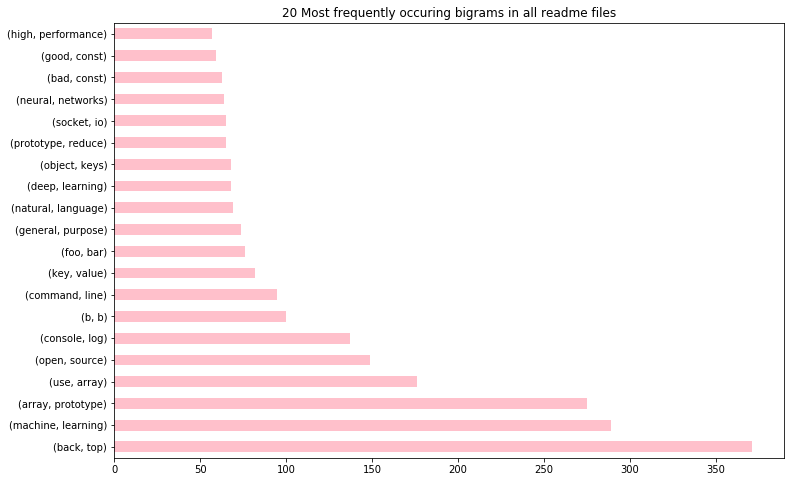

In [51]:
#plot the bigrams of all words
all_bigrams\
    .head(20)\
    .plot.barh(figsize=(12, 8), color='pink')
plt.title('20 Most frequently occuring bigrams in all readme files')

### Let's Look at the bigrams for each common programming language:

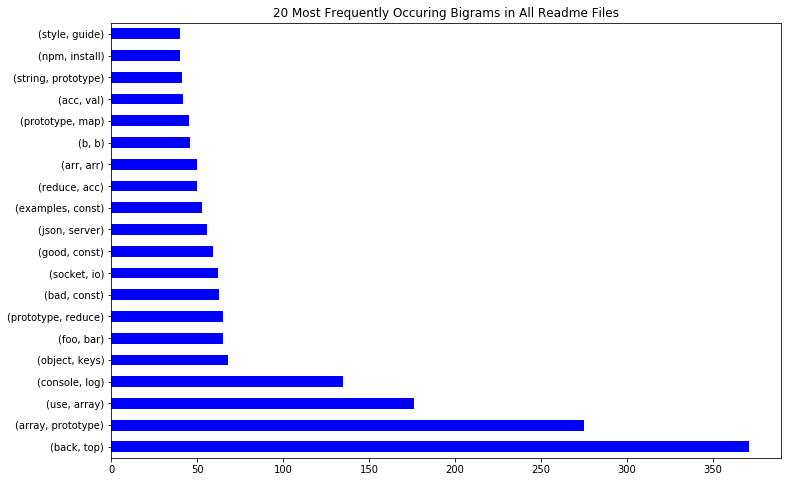

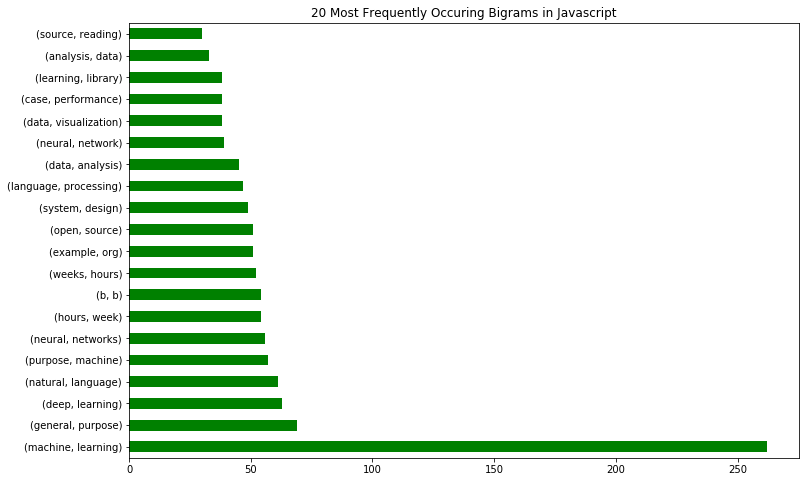

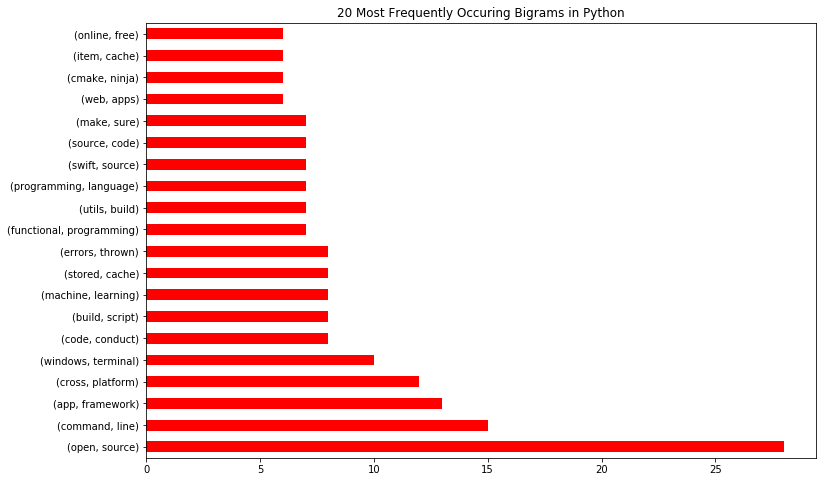

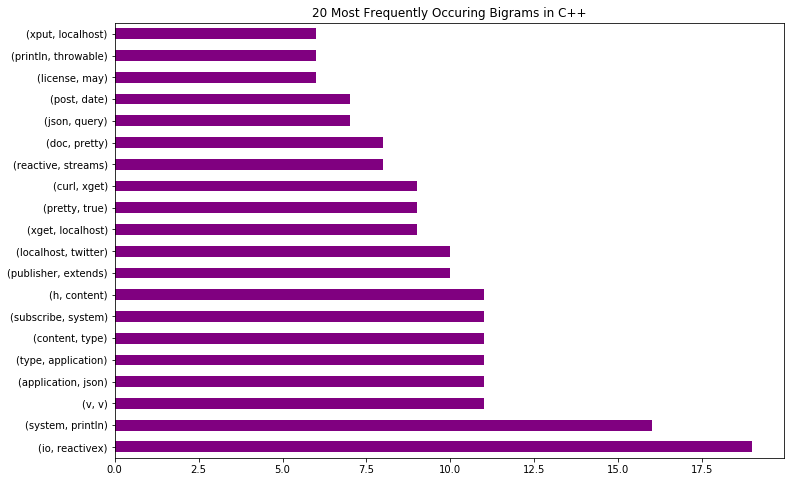

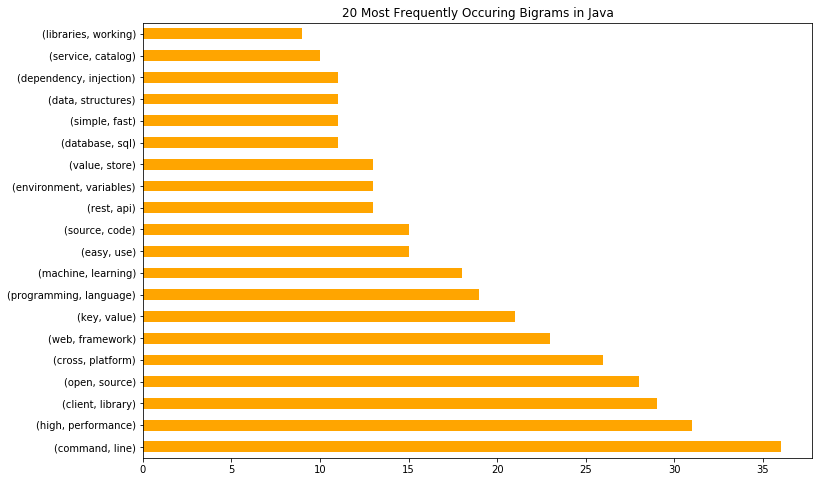

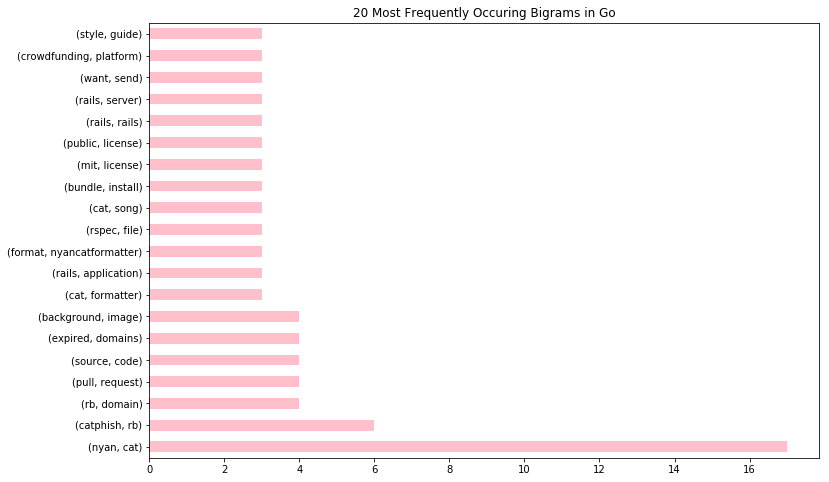

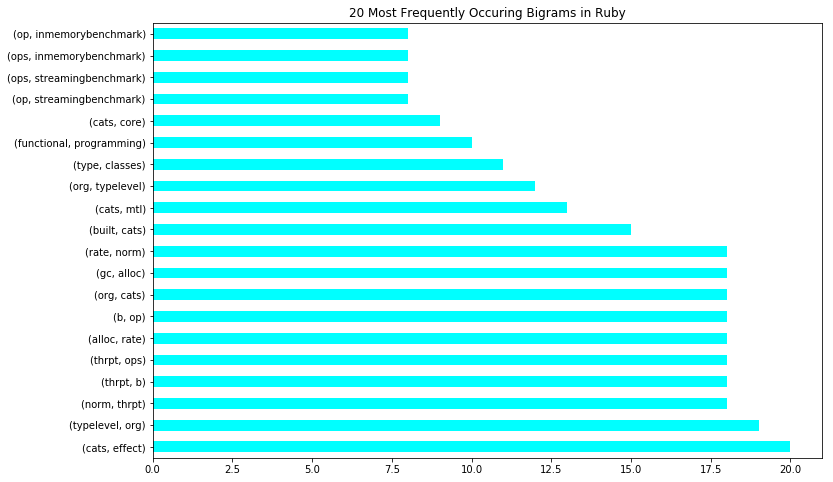

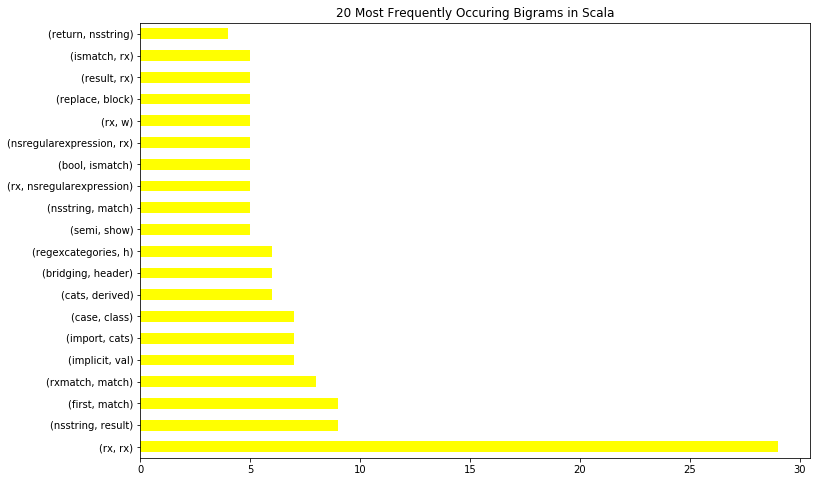

In [52]:
#bar plot the languages:
# list the bigram variable sets
bigrams = [js_bigrams, py_bigrams, cplusplus_bigrams, java_bigrams, go_bigrams, ruby_bigrams, scala_bigrams, objc_bigrams]
# list of colors for variety
colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'cyan', 'yellow']
for n, i in enumerate(bigrams):
    i\
    .head(20)\
    .plot.barh(figsize=(12, 8), color=colors[n])
    plt.title(f'20 Most Frequently Occuring Bigrams in {langs[n]}')
    plt.show()

### Let's look at some word-clouds of bigrams across our dataset!
## First, take a peek at the most common bigrams across the entire set of words:

(-0.5, 799.5, 399.5, -0.5)

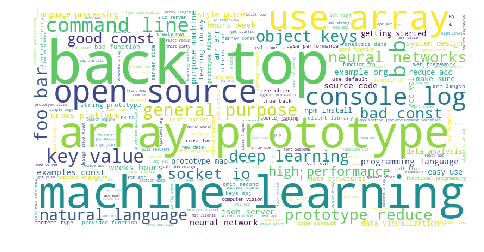

In [53]:
# map a dictionary of bigrams for use in wordcloud plotting:
frequencies = {k[0] + ' ' + k[1]: v for k, v in all_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(frequencies)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

### Let's look at the languages individually now: 

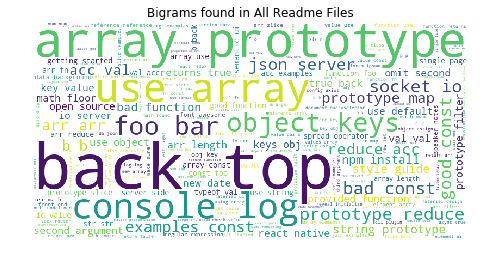

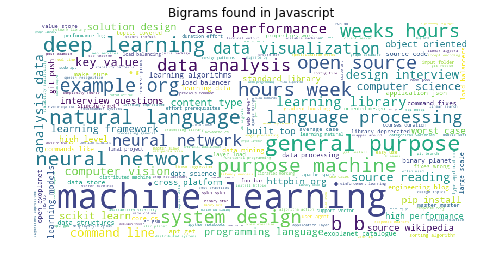

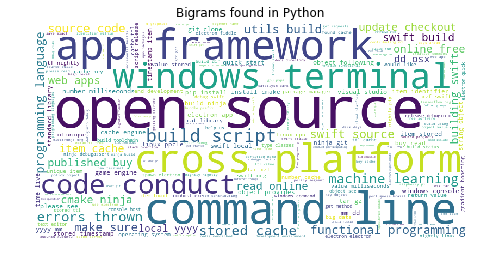

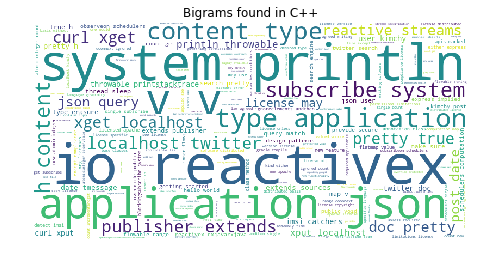

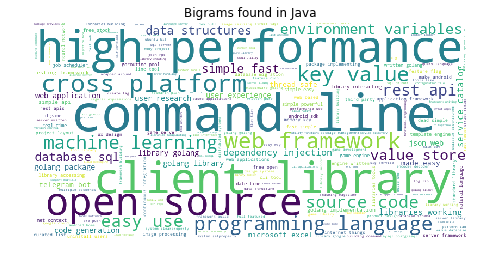

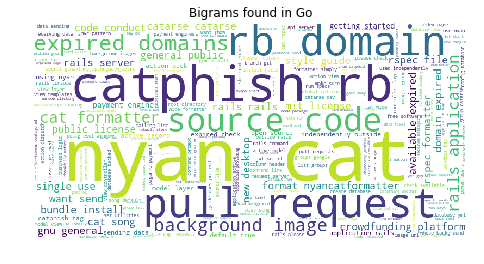

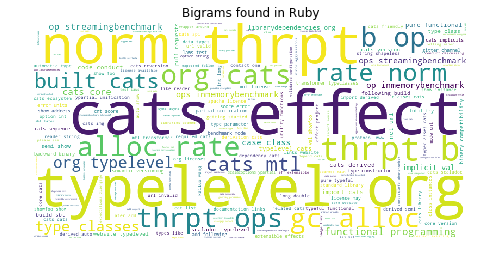

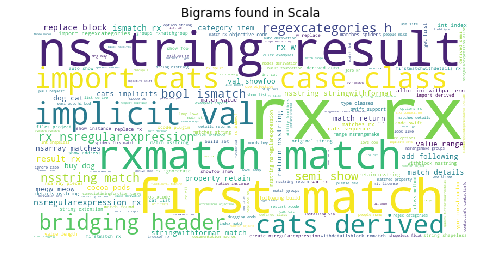

In [54]:
#loop through our languages and create independent wordclouds of each:
for n, item in enumerate(bigrams):
    frequencies = {k[0] + ' ' + k[1]: v for k, v in item\
                   .to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(frequencies)
    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    plt.title(f'Bigrams found in {langs[n]}')
    plt.axis('off')

## TRIGRAMS: N=3

In [55]:
#create our trigrams using nltk, selecting 3 for n in ngrams, made into a series and sorted by value counts
all_trigrams = pd.Series(nltk.ngrams(all_words.strip().split(' '), 3)).value_counts()
js_trigrams = pd.Series(nltk.ngrams(javascript_words.split(' '), 3)).value_counts()
py_trigrams = pd.Series(nltk.ngrams(python_words.split(' '), 3)).value_counts()
java_trigrams = pd.Series(nltk.ngrams(java_words.split(' '), 3)).value_counts()
cplusplus_trigrams = pd.Series(nltk.ngrams(cplusplus_words.split(' '), 3)).value_counts()
go_trigrams = pd.Series(nltk.ngrams(go_words.split(' '), 3)).value_counts()
scala_trigrams = pd.Series(nltk.ngrams(scala_words.split(' '), 3)).value_counts()
ruby_trigrams = pd.Series(nltk.ngrams(ruby_words.split(' '), 3)).value_counts()
objc_trigrams = pd.Series(nltk.ngrams(obj_c_words.split(' '), 3)).value_counts()

Text(0.5, 1.0, '20 Most frequently occuring trigrams in all readme files')

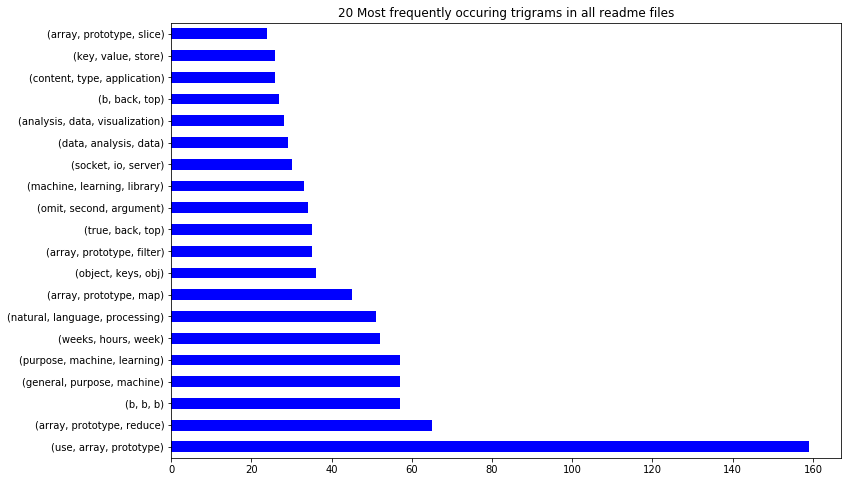

In [56]:
#plot the trigrams of all words
all_trigrams\
    .head(20)\
    .plot.barh(figsize=(12, 8), color='blue')
plt.title('20 Most frequently occuring trigrams in all readme files')

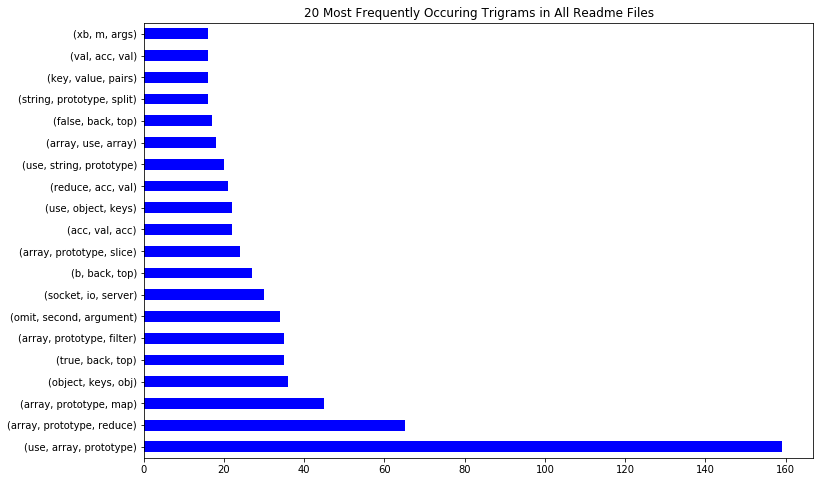

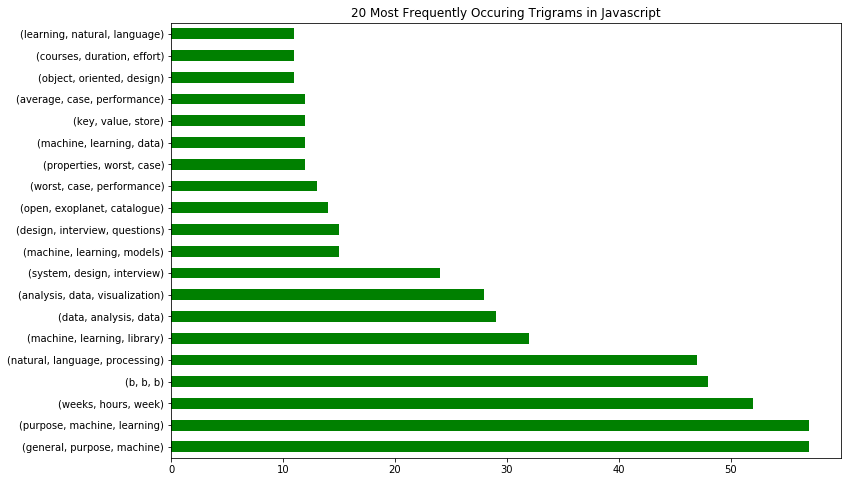

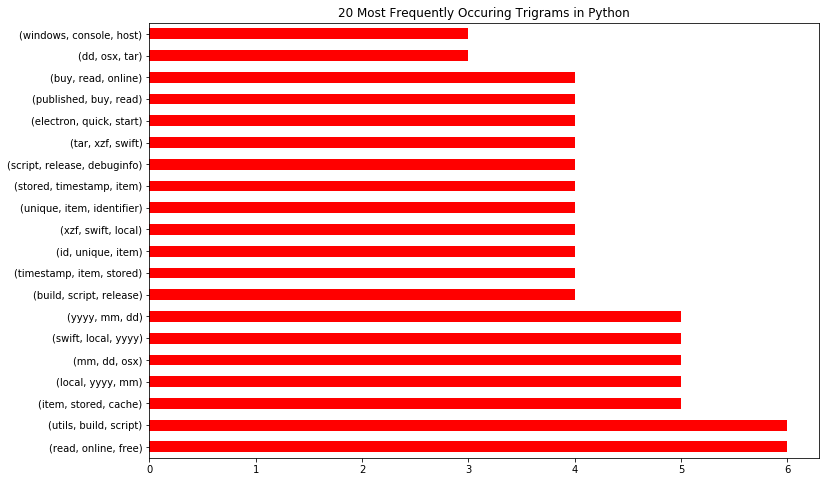

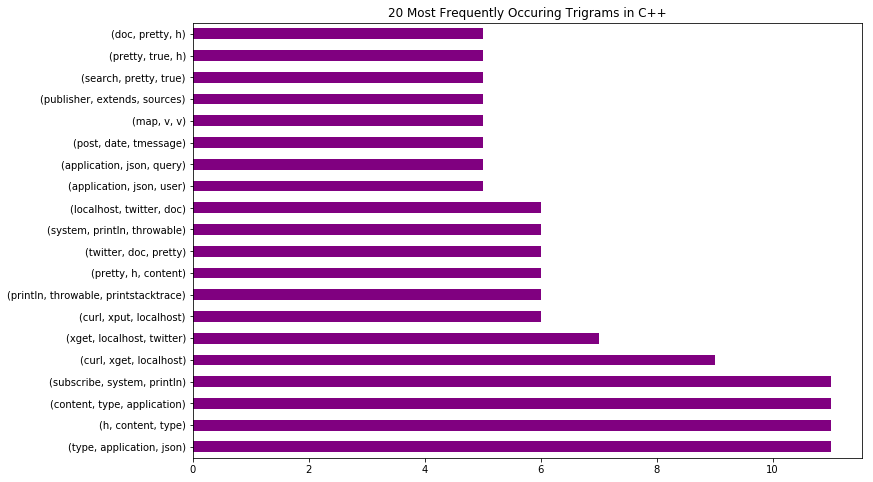

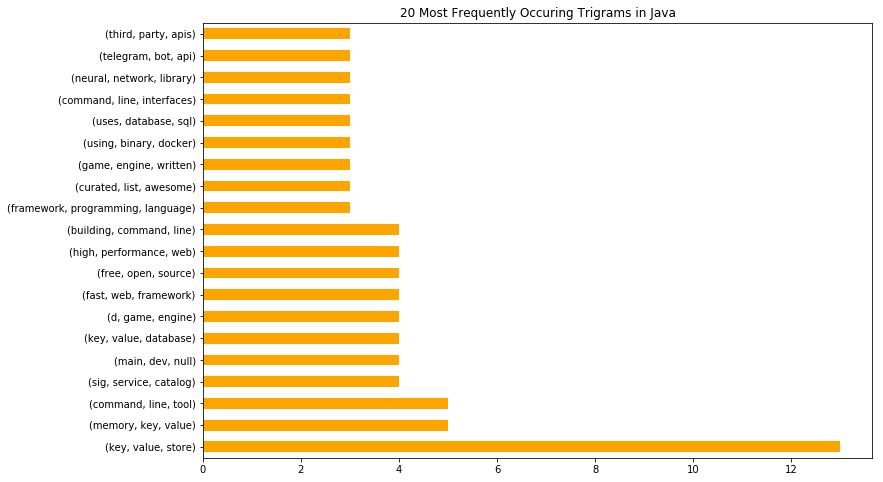

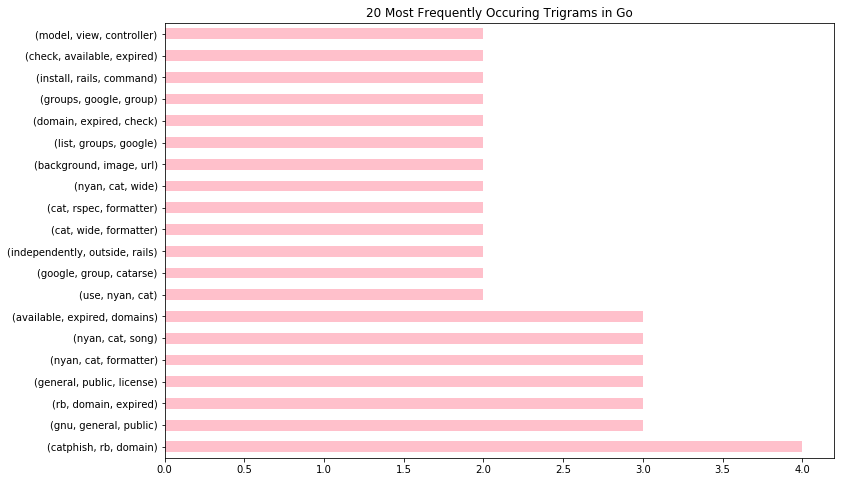

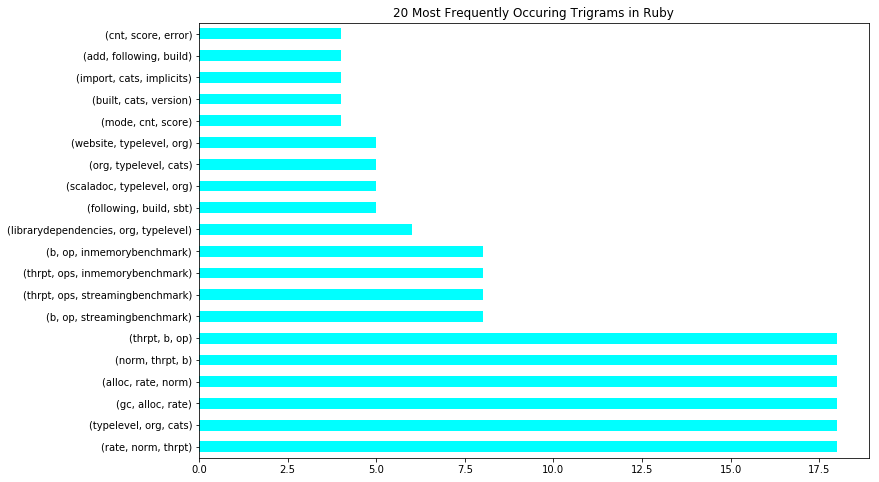

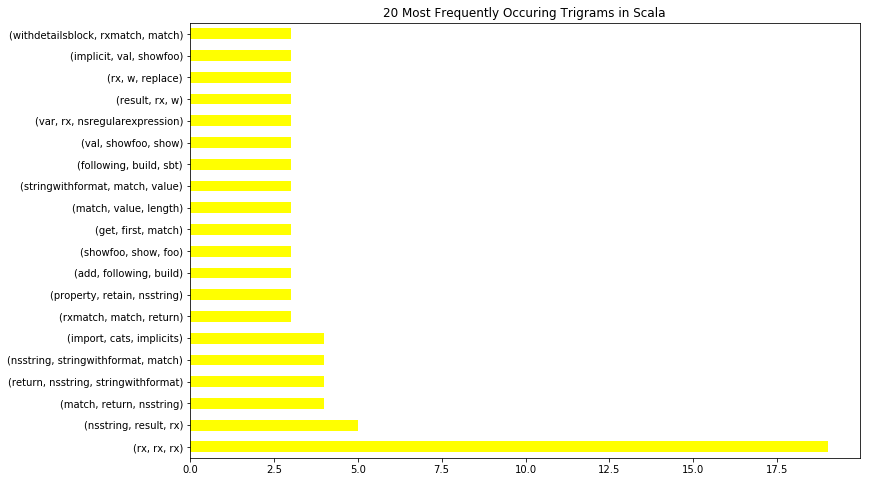

In [57]:
#bar plot the languages:
# list the trigram variable sets
trigrams = [js_trigrams, py_trigrams, cplusplus_trigrams, java_trigrams, go_trigrams, ruby_trigrams, scala_trigrams, objc_trigrams]
# list of colors for variety
colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'cyan', 'yellow']
for n, i in enumerate(trigrams):
    i\
    .head(20)\
    .plot.barh(figsize=(12, 8), color=colors[n])
    plt.title(f'20 Most Frequently Occuring Trigrams in {langs[n]}')
    plt.show()

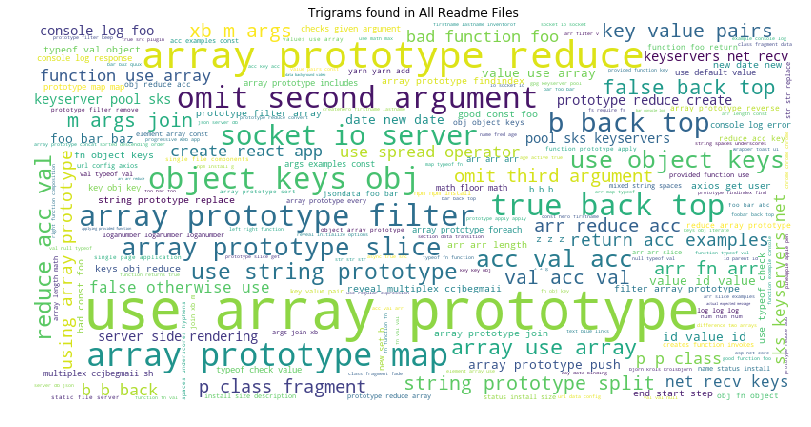

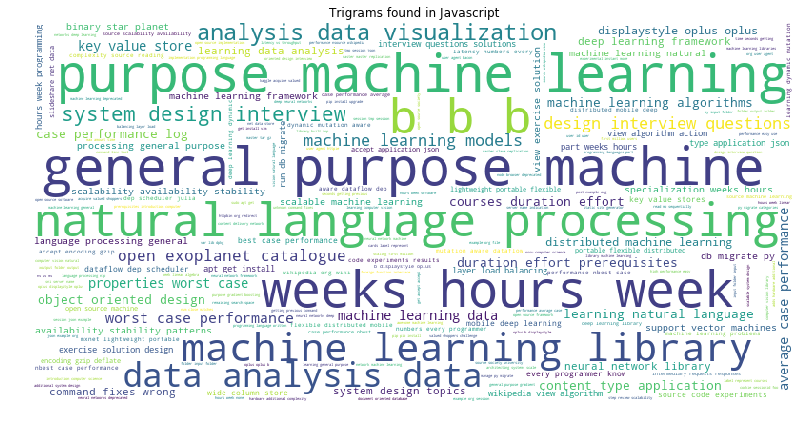

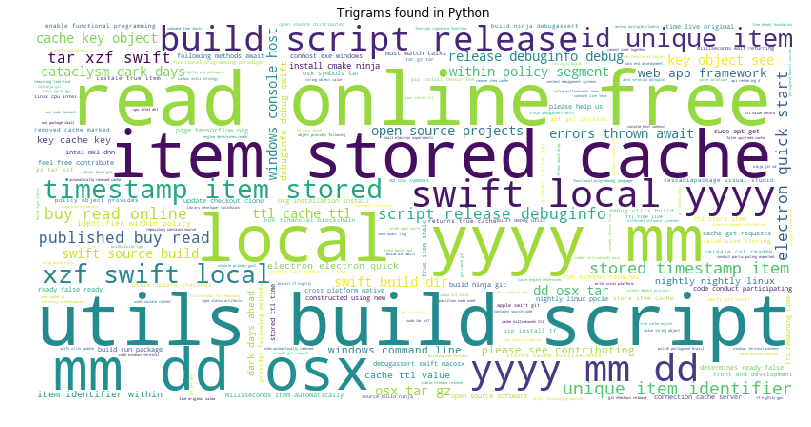

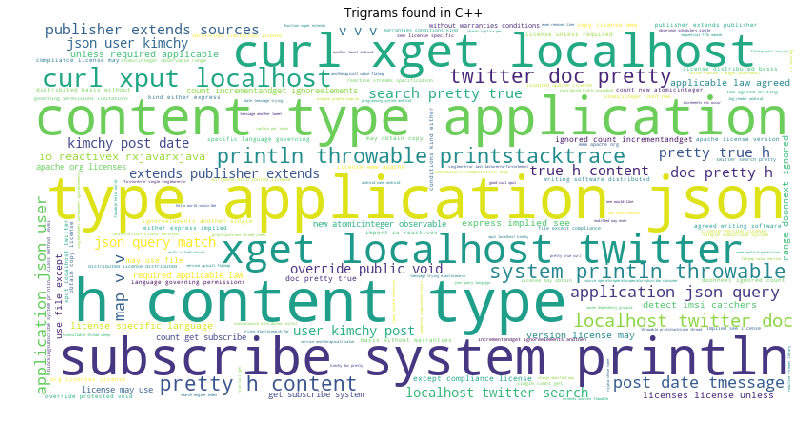

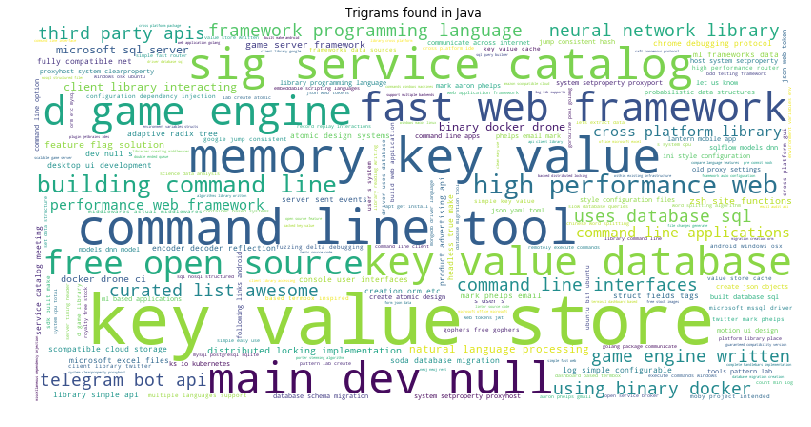

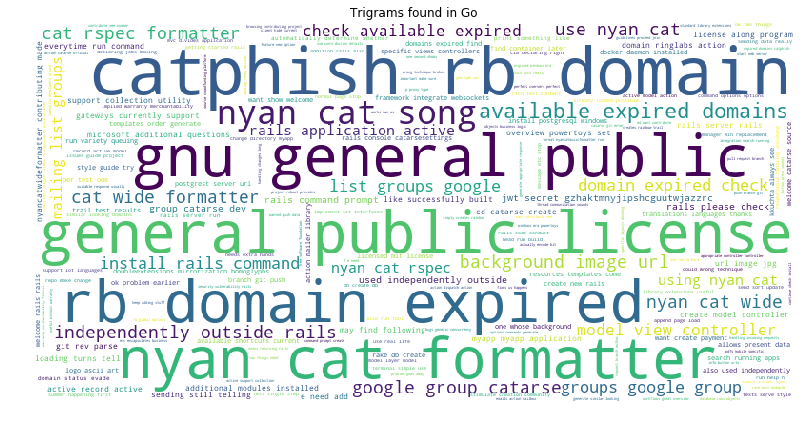

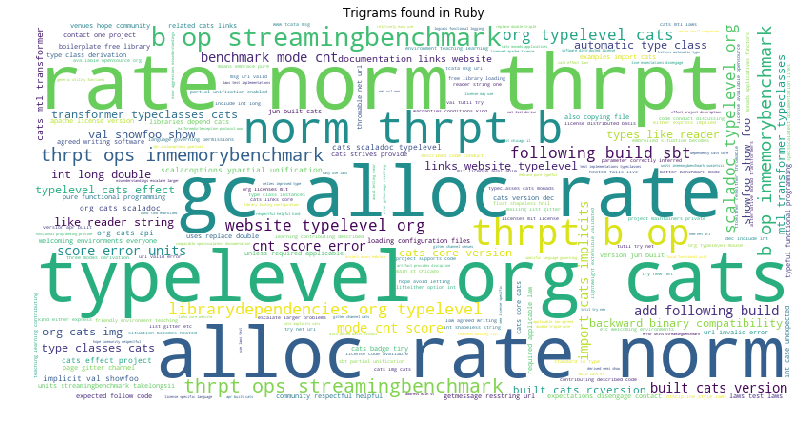

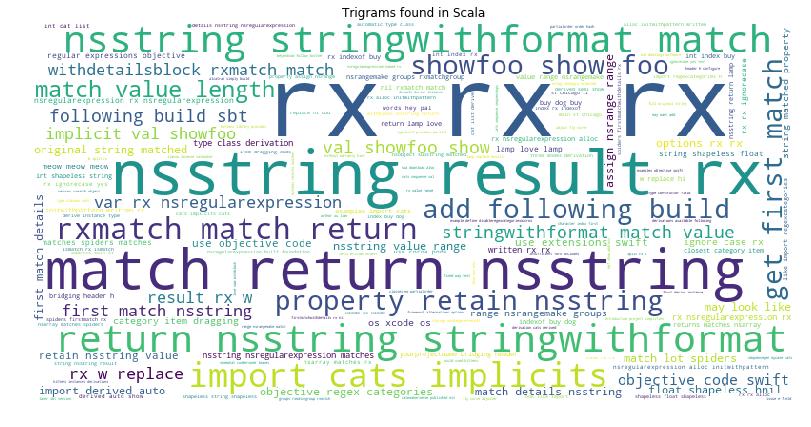

In [58]:
#loop through our languages and create independent wordclouds of each:
for n, item in enumerate(trigrams):
    frequencies = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in item\
                   .to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(frequencies)
    plt.figure(figsize=(15, 7))
    plt.imshow(img)
    plt.title(f'Trigrams found in {langs[n]}')
    plt.axis('off')

# Model

In [59]:
# create our train/test split using sklearn:
# We will elect to use our stemmed text data as this hs been primarily what 
# we are examining in our exploration.
from sklearn.model_selection import train_test_split

#assign train/test variables
X_train, X_test, y_train, y_test = train_test_split(df.stemmed, df.language, stratify=df.language, random_state=123)

In [60]:
# use sklearn to create bag-of-words vectorizer
bag_o_words = CountVectorizer()
bag_o_words.fit(X_train)
train_bag_values = bag_o_words.transform(X_train)

In [61]:
# use sklearn to create tf-idf vectorizer
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
train_tfidf_values = tfidf.transform(X_train)

## Decision Tree

In [62]:
# make a decision tree classifier
from sklearn.tree import DecisionTreeClassifier
clf_tree_1 = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=123)

In [63]:
# fit decision tree model on bag of words
clf_tree_1.fit(train_bag_values, y_train)

# predict based on decision tree utilizing bag of words
y_pred_tree_1 = clf_tree_1.predict(train_bag_values)
y_pred_proba_tree_1 = clf_tree_1.predict_proba(train_bag_values)

# make a dataframe out of it for analysis:
df_tree_1 = pd.DataFrame(dict(actual=y_train, predicted=y_pred_tree_1))

print('Accuracy: {:.2%}'.format(accuracy_score(df_tree_1.actual, df_tree_1.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(df_tree_1.predicted, df_tree_1.actual))
print('---')
print(classification_report(df_tree_1.actual, df_tree_1.predicted))

Accuracy: 55.21%
---
Confusion Matrix
actual      C++  Go  Java  JavaScript  Objective-C  Python  Ruby  Scala
predicted                                                              
C++           2   0     0           0            0       0     1      0
JavaScript    8   8    10          37            4       8     4      0
Python        0   0     0           0            0       9     0      0
Scala         0   0     0           0            0       0     0      5
---
              precision    recall  f1-score   support

         C++       0.67      0.20      0.31        10
          Go       0.00      0.00      0.00         8
        Java       0.00      0.00      0.00        10
  JavaScript       0.47      1.00      0.64        37
 Objective-C       0.00      0.00      0.00         4
      Python       1.00      0.53      0.69        17
        Ruby       0.00      0.00      0.00         5
       Scala       1.00      1.00      1.00         5

   micro avg       0.55      0.55     

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Let's attempt to re-run the same model using TFIDF instad of simpley utilizing bag-of-words.  This should help us weight the model properly as it will consider the amount of times a word appears in a document in addition to how many documents in the corpus the word appears

In [64]:
# refit the model with our calculated tfidf values
clf_tree_2 = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=123)
clf_tree_2.fit(train_tfidf_values, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [65]:
# predict based on decision tree utilizing tfidf
y_pred_tree_2 = clf_tree_2.predict(train_tfidf_values)
y_pred_proba_tree_2 = clf_tree_2.predict_proba(train_tfidf_values)

In [66]:
# make a dataframe out of it for analysis:
df_tree_2 = pd.DataFrame(dict(actual=y_train, predicted=y_pred_tree_2))

In [67]:
print('Accuracy: {:.2%}'.format(accuracy_score(df_tree_2.actual, df_tree_2.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(df_tree_2.predicted, df_tree_2.actual))
print('---')
print(classification_report(df_tree_2.actual, df_tree_2.predicted))

Accuracy: 55.21%
---
Confusion Matrix
actual      C++  Go  Java  JavaScript  Objective-C  Python  Ruby  Scala
predicted                                                              
C++           2   0     0           0            0       0     1      0
JavaScript    8   8    10          37            4       8     4      0
Python        0   0     0           0            0       9     0      0
Scala         0   0     0           0            0       0     0      5
---
              precision    recall  f1-score   support

         C++       0.67      0.20      0.31        10
          Go       0.00      0.00      0.00         8
        Java       0.00      0.00      0.00        10
  JavaScript       0.47      1.00      0.64        37
 Objective-C       0.00      0.00      0.00         4
      Python       1.00      0.53      0.69        17
        Ruby       0.00      0.00      0.00         5
       Scala       1.00      1.00      1.00         5

   micro avg       0.55      0.55     

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Curiously, our bag of words and tf-idf predictions are replicant on our Decision Tree Models.

Let's push for something with greater accuracy.

## Logistic Regression

In [ ]:
lin_model = LogisticRegression(multi_class = 'multinomial', solver='saga')
lin_model.fit(train_tfidf_values, y_train)

y_pred_lin = lin_model.predict(train_tfidf_values)
y_pred_lin_proba = lin_model.predict_proba(train_tfidf_values)

df_lin = pd.DataFrame(dict(actual=y_train, predicted=y_pred_lin))

print('Accuracy: {:.2%}'.format(accuracy_score(df_lin.actual, df_lin.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(df_lin.predicted, df_lin.actual))
print('---')
print(classification_report(df_lin.actual, df_lin.predicted))

In [ ]:
#try with bag of words: 
lin_model2 = LogisticRegression(multi_class = 'multinomial', solver='saga')
lin_model2.fit(train_bag_values, y_train)

y_pred_lin2 = lin_model2.predict(train_bag_values)
y_pred_lin_proba2 = lin_model2.predict_proba(train_bag_values)

df_lin2 = pd.DataFrame(dict(actual=y_train, predicted=y_pred_lin2))

print('Accuracy: {:.2%}'.format(accuracy_score(df_lin2.actual, df_lin2.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(df_lin2.predicted, df_lin2.actual))
print('---')
print(classification_report(df_lin2.actual, df_lin2.predicted))

## SVM

In [ ]:
# make support vector instance
svm = SVC(probability = True, random_state = 123)
# fit it
svm.fit(train_tfidf_values, y_train)
# predict it
y_pred_svm = svm.predict(train_tfidf_values)
# get probabilities
y_pred_proba_svm = svm.predict_proba(train_tfidf_values)
# make dataframe out of results
df_svm = pd.DataFrame(dict(actual=y_train, predicted=y_pred_svm))

print('Accuracy: {:.2%}'.format(accuracy_score(df_svm.actual, df_svm.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(df_svm.predicted, df_svm.actual))
print('---')
print(classification_report(df_svm.actual, df_svm.predicted))

## K Nearest Neighbors

## Utilizing sentiment analysis:

In [ ]:
# use afinn to create sentiment analysis
afinn = Afinn()
df['sentiment'] = df.stemmed.apply(afinn.score)

In [ ]:
# resplit:
# We will elect to use our stemmed text data as this hs been primarily what we are examining in our exploration.
from sklearn.model_selection import train_test_split

#assign train/test variables
X_trainsnt, X_testsnt, y_trainsnt, y_testsnt = train_test_split(df.sentiment, df.language, stratify=df.language, random_state=123)


In [ ]:
lin_models = LogisticRegression(multi_class = 'multinomial', solver='saga')
lin_models.fit(X_trainsnt, y_trainsnt)

y_pred_lins = lin_models.predict(X_trainsnt)
y_pred_lins_proba = lin_models.predict_proba(X_trainsnt)

df_lins = pd.DataFrame(dict(actual=y_trainsnt, predicted=y_pred_lins))

print('Accuracy: {:.2%}'.format(accuracy_score(df_lins.actual, df_lins.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(df_lins.predicted, df_lins.actual))
print('---')
print(classification_report(df_lins.actual, df_lins.predicted))